# PUI2016 HW6 - jp4772
## Assignment 2
### With Ian Wright

In [26]:
import os
import urllib, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
plt.style.use('ggplot')

#### IDEA:

There is demand for expanded citibike service in Upper Manhattan / Harlem / Columbia University.

#### HYPOTHESIS:

$H_0:$ The average rides (normalized per dock) on any given day that *start* along the north edge of the Citibike service zone in Manhattan (all Citibike stations between 86th St. and 81st St.) is *less than or equal to* that of Citibike stations in a similar, but non-boundary, region of Manhattan (between 81st St. and 72nd St). Timeframe set as a most recent complete 4 weeks.

##### $H_0: mean(rides/dock)_{boundary} <= mean(rides/dock)_{non-boundary}$

$H_1:$ The average rides (normalized per bike) on any given day that *start* along the north edge of the Citibike service zone in Manhattan (all Citibike stations between 86th St. and 81st St.) is *greater than* that of Citibike stations in a similar, but non-boundary, region of Manhattan (between 81st St. and 72nd St). Timeframe set as a most recent complete 4 weeks.

##### $H_1: mean(rides/dock)_{boundary} > mean(rides/dock)_{non-boundary}$

#### SIGNIFICANCE LEVEL:

For this test, I'll use a significance level of $\alpha=0.05$



#### DATA STRATEGY:

Citibike provides a json feed of all stations in the system. We'll parse through this to build a list of station IDs, names, and total bike capacity for each.

Then we'll cross-reference a citibike map for the relevant stations for our study, and group our dataset into boundary and non-boundary stations (and drop unneeded stations).

In [2]:
# get station data from citibike station feed
url = "https://feeds.citibikenyc.com/stations/stations.json"
response = urllib.urlopen(url)
stations = json.loads(response.read())

In [3]:
# use list comprehension to build a master list of relevant station data
station_data = [{'id':station['id'],
                 'totalDocks':station['totalDocks']} 
                for station in stations['stationBeanList']] 

Sadly, citibike doesn't provide a map with unique integer IDs for each station... instead, we need to inspect the map and collect a list of strings for stationNames in our boundary and non-boundary zones. Then we'll search the station_data list for those stationNames.

To build the list of boundary and non-boundary station IDs, we inspect a citibike map using open source GIS software (image below). In this case, the yellow-highlighted stations are "non-boundary", and the "boundary" stations are north of that.

NOTE:
Originally, we established a boundary zone even further North in Manhattan. But after looking at trip data from June 2016, we realized that those stations were *too new* (we had no trip data from them in June) - we had to dig into the data to figure out what the "true boundary" stations were at a snapshot in time in June.

![](non-boundary-docks.png)

In [4]:
# list of stationName for boundary zone: 
boundary_ids = [3145, 3147, 3148, 3150, 3157, 3168, 3169, 3170, 3171, 3177]

In [5]:
# list of stationName for non-boundary zone: 
non_boundary_ids = [3135, 3137, 3139, 3140, 3143, 3144, 3146, 3151, 2154, 3156,
                         3160, 3161, 3162, 3164, 3165, 3166, 3167, 3172, 3178, 3226, 3238]

We need to iterate through all station data in the JSON import to pick out those stations that belong in a boundary or non-boundary group.

In [6]:
boundary_stations = []
non_boundary_stations = []
for station in station_data:
    if station['id'] in boundary_ids:
        boundary_stations.append(station)
    elif station['id'] in non_boundary_ids:
        non_boundary_stations.append(station)

In [7]:
boundary_stations

[{'id': 3145, 'totalDocks': 45},
 {'id': 3147, 'totalDocks': 39},
 {'id': 3148, 'totalDocks': 31},
 {'id': 3150, 'totalDocks': 47},
 {'id': 3157, 'totalDocks': 27},
 {'id': 3168, 'totalDocks': 31},
 {'id': 3169, 'totalDocks': 39},
 {'id': 3170, 'totalDocks': 35},
 {'id': 3171, 'totalDocks': 39},
 {'id': 3177, 'totalDocks': 63}]

In [8]:
non_boundary_stations

[{'id': 3135, 'totalDocks': 41},
 {'id': 3137, 'totalDocks': 31},
 {'id': 3139, 'totalDocks': 43},
 {'id': 3140, 'totalDocks': 55},
 {'id': 3143, 'totalDocks': 47},
 {'id': 3144, 'totalDocks': 46},
 {'id': 3146, 'totalDocks': 47},
 {'id': 3151, 'totalDocks': 31},
 {'id': 3156, 'totalDocks': 39},
 {'id': 3160, 'totalDocks': 39},
 {'id': 3161, 'totalDocks': 59},
 {'id': 3162, 'totalDocks': 39},
 {'id': 3164, 'totalDocks': 67},
 {'id': 3165, 'totalDocks': 51},
 {'id': 3166, 'totalDocks': 41},
 {'id': 3167, 'totalDocks': 55},
 {'id': 3172, 'totalDocks': 27},
 {'id': 3178, 'totalDocks': 39},
 {'id': 3226, 'totalDocks': 45},
 {'id': 3238, 'totalDocks': 37}]

Now we load actual trip data from citibike to use as our sample.

In [12]:
# Download the citibike trip data for the last available month.
# At the time of this writing (9/24/2016) that is June 2016.
def get_citibike_data():
    """
    Checks if a citibike dataset already exists on local machine;
    returns data as PD DF if so;
    downloads data to local csv file if not, and returns data as PD DF.
    """
    # if we have the PUIDATA environment variable configured
    if os.getenv('PUIDATA'):
        puidata = os.getenv('PUIDATA')
        print 'data directory:', puidata
        # if the data we need is already downloaded
        if os.path.isfile(puidata + '/201606-citibike-tripdata.zip'):
            print 'file already exists...'
            # is the pluto data already unzipped?
            if os.path.isfile(puidata + '/201606-citibike-tripdata.csv'):
                print 'data returned as pandas DF.'
                return pd.read_csv(puidata + '/201606-citibike-tripdata.csv')
            # first need to unzip the data
            else:
                print 'unzipping data...'
                !unzip -o $PUIDATA/201606-citibike-tripdata.zip -d $PUIDATA
                print 'data written to csv file...'
                print 'data returned as pandas DF.'
                return pd.read_csv(puidata + '/201606-citibike-tripdata.csv')
        # data we need is not yet downloaded
        else:
            print 'must download data...'
            !curl -o $PUIDATA/201606-citibike-tripdata.zip 'https://s3.amazonaws.com/tripdata/201606-citibike-tripdata.zip'
            print 'unzipping data...'
            !unzip -o $PUIDATA/201606-citibike-tripdata.zip -d $PUIDATA
            print 'data written to csv file...'
            print 'data returned as pandas DF.'
            return pd.read_csv(puidata + '/201606-citibike-tripdata.csv')
    # must configure PUIDATA variable and try again
    else:
        print 'Please configure a "PUIDATA" environment variable and try again.'

In [13]:
# Import trip data into a pandas dataframe
#trips = pd.read_csv('201606-citibike-tripdata.csv')
trips = get_citibike_data()

data directory: /Users/ian/school/hw/PUI2016/PUIDATA
file already exists...
unzipping data...
Archive:  /Users/ian/school/hw/PUI2016/PUIDATA/201606-citibike-tripdata.zip
  inflating: /Users/ian/school/hw/PUI2016/PUIDATA/201606-citibike-tripdata.csv  
data written to csv file...
data returned as pandas DF.


In [14]:
trips.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1470,6/1/2016 00:00:18,6/1/2016 00:24:48,380,W 4 St & 7 Ave S,40.734011,-74.002939,3236,W 42 St & Dyer Ave,40.758985,-73.993800,19859,Subscriber,1972.0,1
1,229,6/1/2016 00:00:20,6/1/2016 00:04:09,3092,Berry St & N 8 St,40.719009,-73.958525,3103,N 11 St & Wythe Ave,40.721533,-73.957824,16233,Subscriber,1967.0,1
2,344,6/1/2016 00:00:21,6/1/2016 00:06:06,449,W 52 St & 9 Ave,40.764618,-73.987895,469,Broadway & W 53 St,40.763441,-73.982681,22397,Subscriber,1989.0,1
3,1120,6/1/2016 00:00:28,6/1/2016 00:19:09,522,E 51 St & Lexington Ave,40.757148,-73.972078,401,Allen St & Rivington St,40.720196,-73.989978,16231,Subscriber,1991.0,1
4,229,6/1/2016 00:00:53,6/1/2016 00:04:42,335,Washington Pl & Broadway,40.729039,-73.994046,285,Broadway & E 14 St,40.734546,-73.990741,15400,Subscriber,1989.0,1


In [15]:
# Drop all columns except for starttime and start station id
trips = trips[["starttime", "start station id"]]

In [16]:
# Take a look at the data
trips.head(3)

,starttime,start station id
0,6/1/2016 00:00:18,380
1,6/1/2016 00:00:20,3092
2,6/1/2016 00:00:21,449


In [17]:
# Convert starttime to datetime datatype in a new column
trips.loc[:, 'start_datetime'] = pd.to_datetime(trips.starttime, format='%m/%d/%Y %H:%M:%S')

In [18]:
# Filter to only 4 weeks of data to represent only 4 instances of every day of the week (4 Mondays, 4 Tuesdays, etc). 
# The last day of June 2016 was Thursday the 30th. Thus, this dataset now captures all rides from Thursday the 3rd at
# midnight to Thursday the 30th at 23:59:59.
trips = trips[trips["start_datetime"] > "2016-06-03 00:00:00"]

# check that the trips data exists for exactly 4 weeks
print 'min trip time: ', trips.start_datetime.min()
print 'max trip time: ', trips.start_datetime.max()

min trip time:  2016-06-03 00:00:12
max trip time:  2016-06-30 23:59:58


In [19]:
# Get relevant trips 
boundary_trips = trips[trips["start station id"].isin([station['id'] for station in boundary_stations])]
non_boundary_trips = trips[trips["start station id"].isin([station['id'] for station in non_boundary_stations])]

In [20]:
# compute total number of docks in both boundary and non-boundary zones
# we'll use these to normalize our trip counts later
boundary_docks = np.array([station['totalDocks'] for station in boundary_stations]).sum()
non_boundary_docks = np.array([station['totalDocks'] for station in non_boundary_stations]).sum()

In [21]:
# create a new column that represents the 'day of month'
# we'll use this to group our trips
boundary_trips.loc[:,'day'] = boundary_trips.start_datetime.map(lambda t: t.day)
non_boundary_trips.loc[:,'day'] = non_boundary_trips.start_datetime.map(lambda t: t.day)

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
# grouping trips by day for each of boundary and non-boundary
boundary_day_count = boundary_trips.groupby('day').count()
non_boundary_day_count = non_boundary_trips.groupby('day').count()

boundary_day_count.drop(["start station id", "start_datetime"], axis=1, inplace=True)
non_boundary_day_count.drop(["start station id", "start_datetime"], axis=1, inplace=True)

boundary_day_count.columns = ["count"]
non_boundary_day_count.columns = ["count"]

boundary_day_count.loc[:, "count_normalized"] = boundary_day_count["count"].divide(boundary_docks)
non_boundary_day_count.loc[:, "count_normalized"] = non_boundary_day_count["count"].divide(non_boundary_docks)

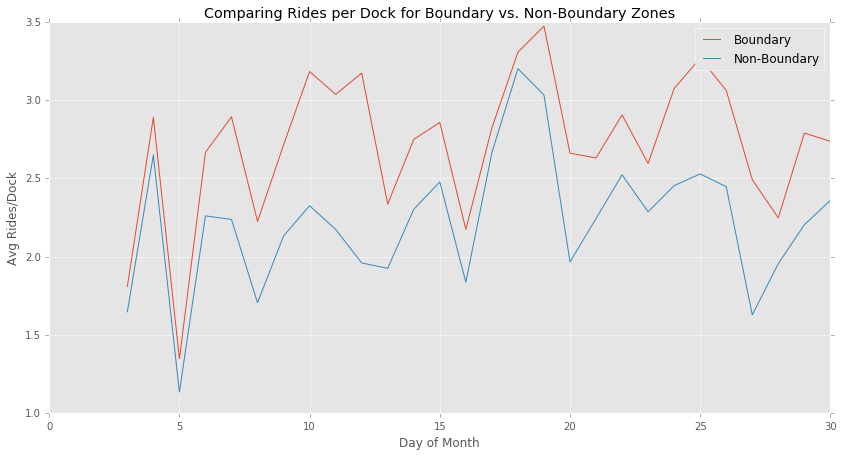

In [23]:
# plot a time series of our two datasets
# in this analysis, the time axis also acts as our set of distinct observations
fig, ax = plt.subplots()
fig.set_size_inches(14,7)

ax.plot(boundary_day_count.index, boundary_day_count.count_normalized, label='Boundary')
ax.plot(non_boundary_day_count.index, non_boundary_day_count.count_normalized, label='Non-Boundary')
ax.set_title('Comparing Rides per Dock for Boundary vs. Non-Boundary Zones')    
ax.set_xlabel('Day of Month')
ax.set_ylabel('Avg Rides/Dock')
ax.legend()

#### FIGURE 1: A time series comparison of Citibike Rides/Dock for each day in a 4 week timeframe through June 2016; a Manhattan boundary zone is comapred against a non-boundary zone.

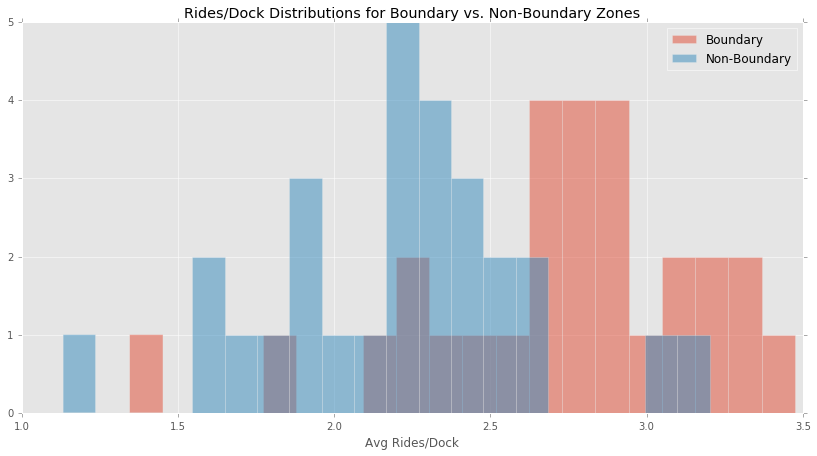

In [24]:
# plot a histogram of rides/dock distributions for both boundary and non-boundary
fig, ax = plt.subplots()
fig.set_size_inches(14,7)

ax.hist(boundary_day_count.count_normalized, bins=20, label='Boundary', alpha=0.5)
ax.hist(non_boundary_day_count.count_normalized, bins=20, label='Non-Boundary', alpha=0.5)
ax.set_title('Rides/Dock Distributions for Boundary vs. Non-Boundary Zones')    
ax.set_xlabel('Avg Rides/Dock')
ax.legend()

#### FIGURE 2: Citibike daily Rides/Dock distributions for a 4 week timeframe through June 2016; a Manhattan boundary zone is comapred against a non-boundary zone.

In [30]:
boundary_day_count.head()

,count,count_normalized
day,,
3,716,1.808081
4,1145,2.891414
5,533,1.345960
6,1056,2.666667
7,1146,2.893939


### Testing the Null hypothesis

$H_0:$ The average rides (normalized per dock) on any given day that *start* along the north edge of the Citibike service zone in Manhattan (all Citibike stations between 86th St. and 81st St.) is *less than or equal to* that of Citibike stations in a similar, but non-boundary, region of Manhattan (between 81st St. and 72nd St). Timeframe set as a most recent complete 4 weeks. Confidence level $\alpha = 0.05$

##### $H_0: mean(rides/dock)_{boundary} <= mean(rides/dock)_{non-boundary}$

In [29]:
# run Welch's t-test for two independent samples of differing variance
# (we don't know that the boundary and non-boundary samples have equal variance... they likely don't, 
# so we defer to Welch's t-test instead of a standard student's t-test)
t, p = stats.ttest_ind(boundary_day_count.count_normalized,
                       non_boundary_day_count.count_normalized,
                       equal_var=False)

print 't-statistic is %f with a p-value of %f' % (t, p)

t-statistic is 4.142997 with a p-value of 0.000122


To interpret this result, we need to find the critical value for our t-test...

In [28]:
# calculate degrees of freedom
df = len(boundary_day_count.count_normalized) + len(non_boundary_day_count.count_normalized) - 2
print 'degrees of freedom:', df

degrees of freedom: 54


At $df=54$ and $\alpha = 0.05$, our critical value for the t-statistic is 1.674 (Figure D-7, Statistics in a Nutshell).

Because our t-statistic is WELL above our critical value, and p-value is well below our 5% confidence level, we can safely REJECT the null hypothesis. This means that it is NOT TRUE that the boundary zone has lower or equal citbike demand to a non-boundary zone. By extension, our alternate hypothesis (boundary zone has higher citibike demand than non-boundary zone) MAY be true... but we can't know this for sure!